<a href="https://colab.research.google.com/github/chaitsugale/Cancer_Detection_CNN/blob/main/chaitanya_ugale_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Assinment for Melanoma Detection

## Step 1 : Loading Package and Importing Files

In [20]:
# importing packages
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [21]:
#importing drive package
from google.colab import drive

In [22]:
#mounting content from google drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [23]:
#unzipping the file

!unzip gdrive/MyDrive/CNN_assignment

Archive:  gdrive/MyDrive/CNN_assignment.zip
replace Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_

In [24]:
# Defining the path for Train and Test

cancer_detection_train = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

cancer_detection_test = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [25]:
# checking the list

!ls

 drive	  sample_data
 gdrive  'Skin cancer ISIC The International Skin Imaging Collaboration'


In [26]:
# checking the image count for train and test

image_count_train = len(list(cancer_detection_train.glob('*/*.jpg')))
image_count_test = len(list(cancer_detection_test.glob('*/*.jpg')))

# printing the count
print('No. of image in Train : ',image_count_train)
print('No. of image in Test : ',image_count_test)

No. of image in Train :  2239
No. of image in Test :  118


## Step 2 : Creating Dataset

In [27]:
# Defining some parameter for the loader

batch_size = 32
image_height = 180
image_width = 180

In [28]:
# writing train dataset for cancer detection

cancer_detection_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    cancer_detection_train,
    seed = 123,
    validation_split = 0.5,
    subset = 'training',
    image_size=(image_height,image_width),
    batch_size=batch_size

)

Found 2239 files belonging to 9 classes.
Using 1120 files for training.


In [29]:
# writing validation dataset for cancer detection

cancer_detection_valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    cancer_detection_train,
    seed = 123,
    validation_split = 0.5,
    subset = 'validation',
    image_size=(image_height,image_width),
    batch_size=batch_size

)

Found 2239 files belonging to 9 classes.
Using 1119 files for validation.


In [30]:
# Listing out class of skin diseases

cancer_class = cancer_detection_train_ds.class_names

In [31]:
print(cancer_class)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Step 3: Dataset Visualization

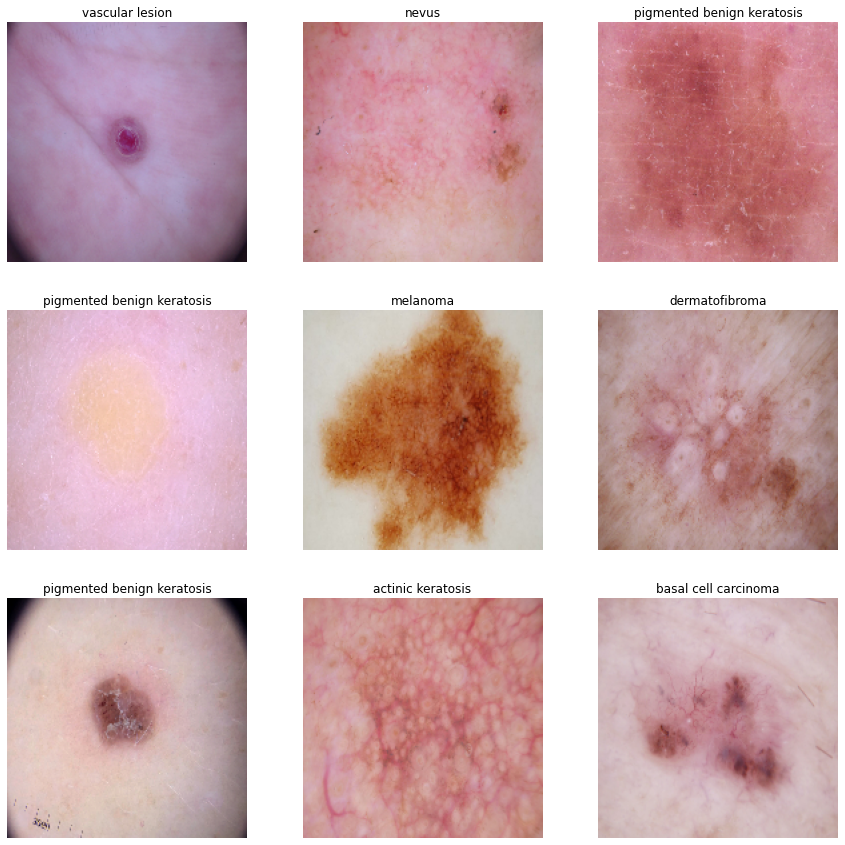

In [32]:
plt.figure(figsize=(15,15))

for cancer_image,cancer_labels in cancer_detection_train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(cancer_image[i].numpy().astype('uint8'))
    plt.title(cancer_class[cancer_labels[i]])
    plt.axis('off')


In [33]:
# Speeding Up Training Dataset to overlap data preprocessing and model execution while training

cancer_data_autotune = tf.data.experimental.AUTOTUNE

cancer_detection_train_ds = cancer_detection_train_ds.cache().shuffle(2000).prefetch(buffer_size=cancer_data_autotune)

cancer_detection_valid_ds = cancer_detection_valid_ds.cache().prefetch(buffer_size=cancer_data_autotune)



## Step 4 : Model Building and Training 

**Creating Model**

In [34]:
cancer_num_class = 9

cancer_model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255,input_shape=(image_height,image_width,3)),
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(cancer_num_class)
]
)

In [35]:
cancer_num_class = 9

cancer_model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size. 
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size. 
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size. 
  layers.MaxPooling2D(),
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.Flatten(),
  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  layers.Dense(128, activation='relu'),
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(cancer_num_class)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])

**Compiling the model**

In [36]:
cancer_model.compile(optimizer='adam',
                     loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     metrics=['accuracy'])

In [37]:
cancer_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

**Model Training**

In [38]:
epochs = 20

cancer_history = cancer_model.fit(
    cancer_detection_train_ds,
    validation_data = cancer_detection_valid_ds,
    epochs = epochs
)

Epoch 1/20
35/35 [==============================] - 187s 5s/step - loss: 2.0955 - accuracy: 0.1902 - val_loss: 2.0391 - val_accuracy: 0.2127
Epoch 2/20
35/35 [==============================] - 174s 5s/step - loss: 1.9613 - accuracy: 0.2562 - val_loss: 1.9078 - val_accuracy: 0.2529
Epoch 3/20
35/35 [==============================] - 174s 5s/step - loss: 1.7536 - accuracy: 0.3607 - val_loss: 1.8315 - val_accuracy: 0.3074
Epoch 4/20
35/35 [==============================] - 174s 5s/step - loss: 1.5809 - accuracy: 0.4295 - val_loss: 1.4779 - val_accuracy: 0.5049
Epoch 5/20
35/35 [==============================] - 173s 5s/step - loss: 1.3957 - accuracy: 0.4946 - val_loss: 1.4559 - val_accuracy: 0.5013
Epoch 6/20
35/35 [==============================] - 174s 5s/step - loss: 1.3003 - accuracy: 0.5312 - val_loss: 1.4207 - val_accuracy: 0.5076
Epoch 7/20
35/35 [==============================] - 173s 5s/step - loss: 1.2377 - accuracy: 0.5554 - val_loss: 1.4200 - val_accuracy: 0.5183
Epoch 8/20
35

**Visualizing Training Result**

In [52]:
#Declaring Accuracy
cancer_accuracy = cancer_history.history['accuracy']

cancer_valid_accuracy = cancer_history.history['val_accuracy']

#Declaring Loss
cancer_loss = cancer_history.history['loss']

cancer_valid_loss = cancer_history.history['val_loss']

epochs_range = range(epochs)


Text(0.5, 1.0, 'Cancer Training and Validation Loss')

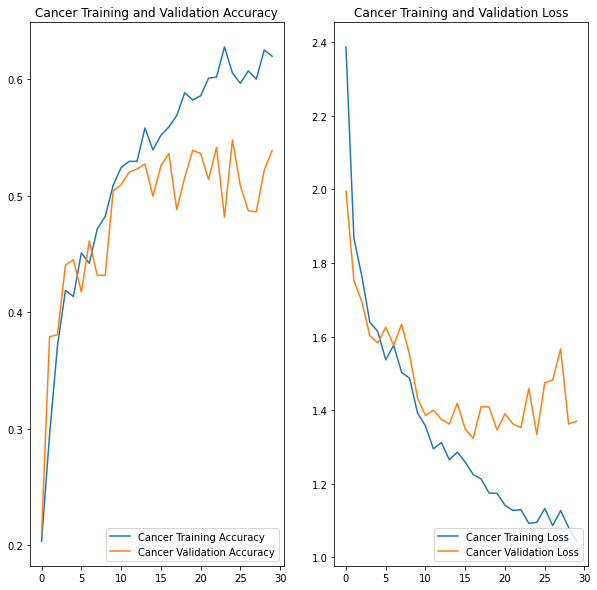

In [53]:
# Plotting Graph for Accuracy and Loss

#Graph for accuracy

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epochs_range,cancer_accuracy,label='Cancer Training Accuracy')
plt.plot(epochs_range,cancer_valid_accuracy,label='Cancer Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Cancer Training and Validation Accuracy")

#Graph for Loss

plt.subplot(1,2,2)
plt.plot(epochs_range,cancer_loss,label='Cancer Training Loss')
plt.plot(epochs_range,cancer_valid_loss,label='Cancer Validation Loss')
plt.legend(loc='lower right')
plt.title("Cancer Training and Validation Loss")

In [54]:
cancer_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(image_height, 
                                                              image_width,
                                                              3)),
    #layers.experimental.preprocessing.RandomRotation(0.6),
    layers.experimental.preprocessing.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), fill_mode='constant'),
  ]
)

In [55]:
cancer_image_batch = tf.cast(tf.expand_dims(cancer_image[0],0),tf.float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


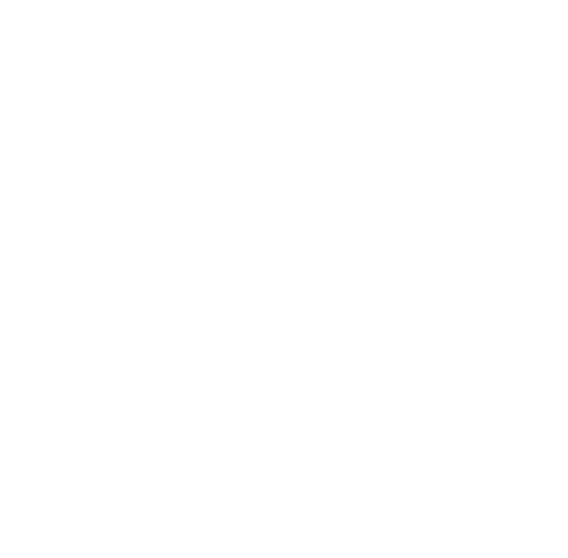

In [56]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = cancer_augmentation(cancer_image_batch)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

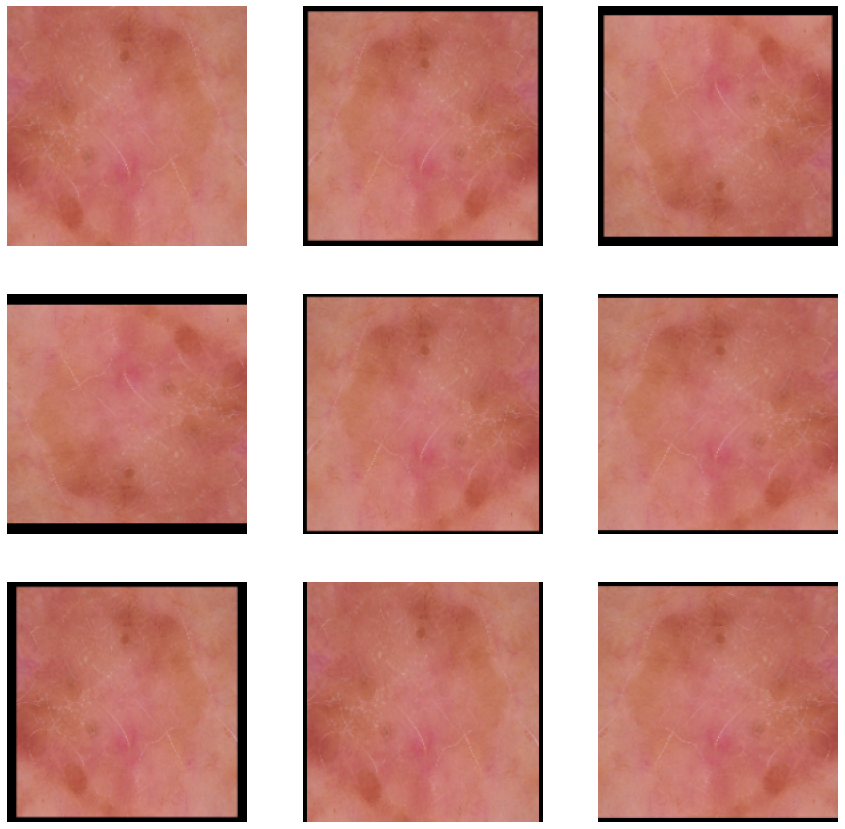

In [44]:
plt.figure(figsize=(15,15))

for image,_ in cancer_detection_train_ds.take(1):
  for i in range(9):
    augmented_images = cancer_augmentation(image)
    ax = plt.subplot(3,3,i+1)
    plt.imshow(augmented_images[0].numpy().astype('uint8'))
    plt.axis('off')

In [45]:
# creating the model using augmentation

cancer_num_class = 9

cancer_model = Sequential([
    cancer_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),  
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(cancer_num_class)         
])

In [46]:
cancer_model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [57]:
epochs = 30

cancer_history = cancer_model.fit(
    cancer_detection_train_ds,
    validation_data=cancer_detection_valid_ds,
    epochs = epochs
)

Epoch 1/30
35/35 [==============================] - 48s 1s/step - loss: 1.0051 - accuracy: 0.6402 - val_loss: 1.6056 - val_accuracy: 0.5022
Epoch 2/30
35/35 [==============================] - 48s 1s/step - loss: 1.0145 - accuracy: 0.6321 - val_loss: 1.3819 - val_accuracy: 0.5326
Epoch 3/30
35/35 [==============================] - 48s 1s/step - loss: 1.0617 - accuracy: 0.6116 - val_loss: 1.4157 - val_accuracy: 0.5487
Epoch 4/30
35/35 [==============================] - 47s 1s/step - loss: 1.0219 - accuracy: 0.6125 - val_loss: 1.5221 - val_accuracy: 0.5353
Epoch 5/30
35/35 [==============================] - 47s 1s/step - loss: 1.0016 - accuracy: 0.6348 - val_loss: 1.4062 - val_accuracy: 0.5612
Epoch 6/30
35/35 [==============================] - 47s 1s/step - loss: 0.9545 - accuracy: 0.6455 - val_loss: 1.4335 - val_accuracy: 0.5335
Epoch 7/30
35/35 [==============================] - 47s 1s/step - loss: 0.9882 - accuracy: 0.6366 - val_loss: 1.4921 - val_accuracy: 0.5264
Epoch 8/30
35/35 [==

In [58]:
#Declaring Accuracy
cancer_accuracy = cancer_history.history['accuracy']

cancer_valid_accuracy = cancer_history.history['val_accuracy']

#Declaring Loss
cancer_loss = cancer_history.history['loss']

cancer_valid_loss = cancer_history.history['val_loss']

epochs_range = range(epochs)

Text(0.5, 1.0, 'Cancer Training and Validation Loss')

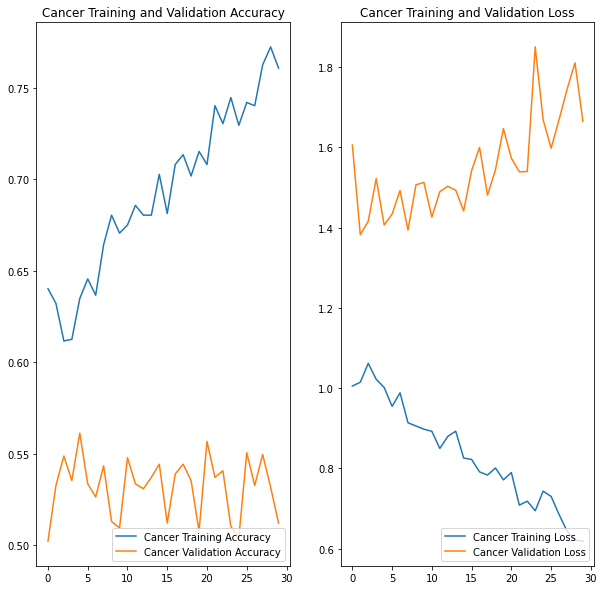

In [59]:
# Plotting Graph for Accuracy and Loss

#Graph for accuracy

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epochs_range,cancer_accuracy,label='Cancer Training Accuracy')
plt.plot(epochs_range,cancer_valid_accuracy,label='Cancer Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Cancer Training and Validation Accuracy")

#Graph for Loss

plt.subplot(1,2,2)
plt.plot(epochs_range,cancer_loss,label='Cancer Training Loss')
plt.plot(epochs_range,cancer_valid_loss,label='Cancer Validation Loss')
plt.legend(loc='lower right')
plt.title("Cancer Training and Validation Loss")

In [60]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Setting batch size and image size
batch_size = 100
IMG_SHAPE = 224 

# Create training images generator
#Generate batches of tensor image data with real-time data augmentation.
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    vertical_flip=True,
                    zoom_range=0.5
                    )
#https://keras.io/api/preprocessing/image/
#Then calling image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset that yields batches of images from the subdirectories
train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=cancer_detection_train,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

# Create validation images generator
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=cancer_detection_test,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [61]:
from glob import glob

cancer_path = [x for x in glob(os.path.join(cancer_detection_train,'*','*.jpg'))]

cancer_lension = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(cancer_detection_train,'*','*.jpg'))]

len(cancer_path)

2239

In [62]:
cancer_dict =dict(zip(cancer_path,cancer_lension))

cancer_data = pd.DataFrame(list(cancer_dict.items()),columns=['Path','Cancer Label'])

cancer_data


,Path,Cancer Label
0,/content/Skin cancer ISIC The International Sk...,nevus
1,/content/Skin cancer ISIC The International Sk...,nevus
2,/content/Skin cancer ISIC The International Sk...,nevus
3,/content/Skin cancer ISIC The International Sk...,nevus
4,/content/Skin cancer ISIC The International Sk...,nevus
...,...,...
2234,/content/Skin cancer ISIC The International Sk...,melanoma
2235,/content/Skin cancer ISIC The International Sk...,melanoma
2236,/content/Skin cancer ISIC The International Sk...,melanoma
2237,/content/Skin cancer ISIC The International Sk...,melanoma


Cancer Class = 4 , count = 357 , count percent = 15.945%
Cancer Class = 0 , count = 114 , count percent = 5.092%
Cancer Class = 8 , count = 139 , count percent = 6.208%
Cancer Class = 2 , count = 95 , count percent = 4.243%
Cancer Class = 1 , count = 376 , count percent = 16.793%
Cancer Class = 6 , count = 77 , count percent = 3.439%
Cancer Class = 5 , count = 462 , count percent = 20.634%
Cancer Class = 7 , count = 181 , count percent = 8.084%
Cancer Class = 3 , count = 438 , count percent = 19.562%


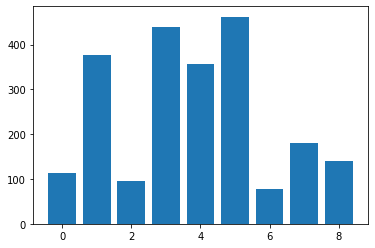

In [64]:
from sklearn.preprocessing import LabelEncoder

from collections import Counter

X,y = cancer_data['Path'],cancer_data['Cancer Label']

y = LabelEncoder().fit_transform(y)

counter = Counter(y)

for k,v in counter.items():
  per = v/len(y)*100
  print('Cancer Class = %d , count = %d , count percent = %.3f%%'%(k,v,per))

plt.bar(counter.keys(),counter.values())

plt.show()

In [65]:
## Augmentor